# Notebook 04 — ZuCo Models (v1+v2): KEC × Dataset/Task (v4.3, Upgraded)

OLS (clustered SE), FDR, MixedLM (Subject + vc SentenceID), Bootstrap (joblib), partial plots & EEG trends.


In [1]:
import os, time, warnings, re
from pathlib import Path
import numpy as np, pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
SEED=42; np.random.seed(SEED)
FIG_DIR=Path('figures/metrics'); FIG_DIR.mkdir(parents=True, exist_ok=True)
PROC_DIR=Path('../data/processed'); PROC_DIR.mkdir(parents=True, exist_ok=True)
RPT_DIR=Path('reports'); RPT_DIR.mkdir(parents=True, exist_ok=True)
def heartbeat(m): print(f"[{time.strftime('%H:%M:%S')}] {m}")
def norm_token(s):
    if not isinstance(s,str): return s
    s=s.lower(); s=re.sub(r'[\W_]+','',s); return s
heartbeat('Env ready')


[06:34:24] Env ready


In [2]:
# Load ZuCo + KEC, normalize tokens, and merge robustly
import pandas as pd, re
from pathlib import Path

def norm_token(s):
    if not isinstance(s, str):
        return s
    s = s.lower()
    s = re.sub(r"[\W_]+", "", s)
    return s

print(f"PROC_DIR: {PROC_DIR}")
zuco_path_default = PROC_DIR / 'zuco_aligned.csv'
zuco_path_alt = PROC_DIR / 'zuco_word_level_all_subjects.csv'  # multi-subject source
kec_path = PROC_DIR / 'kec' / 'metrics_en.csv'
print(f"ZuCo default: {zuco_path_default}")
print(f"ZuCo alt:     {zuco_path_alt}")
print(f"KEC path:     {kec_path}")

# Prefer multi-subject file if available
if zuco_path_alt.exists():
    zuco = pd.read_csv(zuco_path_alt, low_memory=False)
    # Harmonize expected columns
    if 'subject' in zuco.columns and 'Subject' not in zuco.columns:
        zuco['Subject'] = zuco['subject'].astype(str)
    # Task: use provided if exists; else map tsr (1->TSR, 0->NR) when present
    if 'Task' not in zuco.columns:
        if 'task' in zuco.columns:
            zuco['Task'] = zuco['task'].astype(str)
        elif 'tsr' in zuco.columns:
            zuco['Task'] = zuco['tsr'].map({1: 'TSR', 0: 'NR'}).fillna('Unknown').astype(str)
    if 'Dataset' not in zuco.columns:
        zuco['Dataset'] = 'v1'
else:
    zuco = pd.read_csv(zuco_path_default, low_memory=False) if zuco_path_default.exists() else pd.DataFrame()

kec  = pd.read_csv(kec_path) if kec_path.exists() else pd.DataFrame()
print(f"ZuCo exists: {len(zuco)>0}  KEC exists: {kec_path.exists()}")

if len(zuco) > 0:
    # word column variants
    word_src = 'Word' if 'Word' in zuco.columns else ('word' if 'word' in zuco.columns else None)
    if word_src:
        zuco['token_norm'] = zuco[word_src].astype(str).map(norm_token)

if len(kec) > 0:
    kec.columns = [c.strip() for c in kec.columns]
    # token_norm source
    src_word = 'token_norm' if 'token_norm' in kec.columns else (
        'node' if 'node' in kec.columns else (
        'word' if 'word' in kec.columns else (
        'Word' if 'Word' in kec.columns else None)))
    if src_word and 'token_norm' not in kec.columns:
        kec['token_norm'] = kec[src_word].astype(str).map(norm_token)
    # curvature alias
    if 'curvature' not in kec.columns and 'avg_curvature' in kec.columns:
        kec = kec.rename(columns={'avg_curvature': 'curvature'})

# Build required KEC view, creating missing cols if needed
required_kec_cols = ['token_norm', 'entropy', 'curvature', 'coherence']
if len(kec) > 0:
    for col in required_kec_cols:
        if col not in kec.columns:
            kec[col] = pd.NA
    kec_view = kec[required_kec_cols]
else:
    kec_view = pd.DataFrame(columns=required_kec_cols)

# Merge on token_norm only if present on both sides
if len(zuco) > 0 and 'token_norm' in zuco.columns and 'token_norm' in kec_view.columns:
    merged = zuco.merge(kec_view, on='token_norm', how='left', suffixes=('', '_kec'))
else:
    merged = pd.DataFrame()

print(f"Merged shape: {merged.shape if len(merged)>0 else 'N/A'}")
if len(merged)>0 and 'Subject' in merged.columns:
    try:
        print('Subjects:', merged['Subject'].nunique(), 'Tasks:', merged['Task'].nunique() if 'Task' in merged.columns else 'NA')
    except Exception:
        pass

PROC_DIR: ../data/processed
ZuCo default: ../data/processed/zuco_aligned.csv
ZuCo alt:     ../data/processed/zuco_word_level_all_subjects.csv
KEC path:     ../data/processed/kec/metrics_en.csv
ZuCo exists: True  KEC exists: True
Merged shape: (17523, 18)
Subjects: 3 Tasks: 2
Merged shape: (17523, 18)
Subjects: 3 Tasks: 2


## Inputs and coverage summary

This section validates inputs (ZuCo/KEC) and reports ET/KEC coverage before modeling.

In [18]:
# Quick inputs and coverage summary
from pathlib import Path

print("=== INPUTS ===")
print(f"ZuCo source exists: {len(zuco)>0 if 'zuco' in locals() else False}")
print(f"KEC file present: {(PROC_DIR/'kec'/'metrics_en.csv').exists() if 'PROC_DIR' in locals() else False}")
print(f"Merged has data: {len(merged)>0 if 'merged' in locals() else False}")

print("\n=== COVERAGE (non-null fraction) ===")
if 'merged' in locals() and isinstance(merged, pd.DataFrame) and len(merged)>0:
    cols_et = [c for c in ['FFD','GD','TRT','GPT','log_TRT','log_GPT'] if c in merged.columns]
    cols_kec = [c for c in ['entropy','curvature','coherence'] if c in merged.columns]
    for group_name, cols in [("ET", cols_et), ("KEC", cols_kec)]:
        if cols:
            cov = merged[cols].notna().mean().sort_index()
            print(f"{group_name}:")
            for c,v in cov.items():
                print(f"  {c}: {v:0.3f}")
        else:
            print(f"{group_name}: none present")
else:
    print("No merged data available for coverage.")

=== INPUTS ===
ZuCo source exists: True
KEC file present: True
Merged has data: True

=== COVERAGE (non-null fraction) ===
ET:
  FFD: 0.997
  GD: 0.997
  TRT: 0.000
KEC:
  coherence: 0.939
  curvature: 0.939
  entropy: 0.939


In [19]:
# Process merged data
df=merged.copy()
if len(df)>0:
    df=df.rename(columns={'LogFreq':'log_freq'})
    # Map duration_ms to TRT if standard fields are absent
    if 'TRT' not in df.columns and 'duration_ms' in df.columns:
        df['TRT']=df['duration_ms']
    # Create logs where applicable
    for resp in ('TRT','GPT'):
        if resp in df: df[f'log_{resp}']=np.log1p(df[resp])
    # Categorical harmonization
    for cat in ('Dataset','Task','Subject','SentenceID'):
        if cat in df: df[cat]=df[cat].astype(str)
    # Eye-tracking columns with fallbacks
    possible_resps=('FFD','GD','log_TRT','log_GPT','TRT','duration_ms')
    ET_COLS=[c for c in possible_resps if c in df.columns]
    KEC_COLS=[c for c in ('entropy','curvature','coherence') if c in df.columns]
    COVS=[c for c in ('length','log_freq','surprisal') if c in df.columns]
    heartbeat(f'ET:{ET_COLS} KEC:{KEC_COLS} COVS:{COVS}')
else:
    heartbeat('No merged data to process')

[06:35:32] ET:['FFD', 'GD', 'log_TRT', 'TRT', 'duration_ms'] KEC:['entropy', 'curvature', 'coherence'] COVS:[]


In [5]:
# Debug data structure
print("=== DEBUG DATA STRUCTURE ===")
print(f"df shape: {df.shape}")
print(f"df columns: {list(df.columns)}")

# Check for NaN values
nan_counts = df.isnull().sum()
print(f"NaN counts per column:\n{nan_counts[nan_counts > 0]}")

# Check categorical variables
for cat in ['Dataset', 'Task', 'Subject']:
    if cat in df.columns:
        unique_vals = df[cat].unique()
        print(f"{cat} unique values: {len(unique_vals)} - {unique_vals[:5]}...")

# Check numeric columns
numeric_cols = ['FFD', 'GD', 'log_TRT', 'log_GPT', 'entropy', 'curvature', 'coherence']
for col in numeric_cols:
    if col in df.columns:
        non_nan = df[col].notna().sum()
        print(f"{col}: {non_nan} non-NaN values")

print("=== END DEBUG ===")

=== DEBUG DATA STRUCTURE ===
df shape: (17523, 19)
df columns: ['Subject', 'Task', 'Dataset', 'SentenceID', 'Word', 'token_norm', 'duration_ms', 'fixation_samples', 'FFD', 'GD', 'TRT', 'ThetaPower', 'AlphaPower', 'BetaPower', 'GammaPower', 'entropy', 'curvature', 'coherence', 'log_TRT']
NaN counts per column:
Word                   20
duration_ms         17475
fixation_samples    17475
FFD                    48
GD                     49
TRT                 17522
ThetaPower             48
AlphaPower             48
BetaPower           17522
GammaPower          17522
entropy              1073
curvature            1073
coherence            1073
log_TRT             17522
dtype: int64
Dataset unique values: 2 - ['v1' 'v2']...
Task unique values: 2 - ['NR' 'TSR']...
Subject unique values: 3 - ['ZKW' 'ZAB' 'YAC']...
FFD: 17475 non-NaN values
GD: 17474 non-NaN values
log_TRT: 1 non-NaN values
entropy: 16450 non-NaN values
curvature: 16450 non-NaN values
coherence: 16450 non-NaN values
=== END D

In [6]:
# Debug categorical variables variation
print("=== DEBUG CATEGORICAL VARIATION ===")
# Choose an available ET measure for filtering
et_for_debug = next((c for c in ['FFD','GD','log_TRT','TRT','duration_ms'] if c in df.columns), None)
subset_cols = [c for c in [et_for_debug,'entropy','curvature','coherence'] if c is not None]
if subset_cols:
    df_clean = df.dropna(subset=subset_cols)
    print(f"After NaN removal: {len(df_clean)} rows")
else:
    df_clean = df.copy(); print("No ET column available for debug subset")

for cat in ['Dataset', 'Task', 'Subject']:
    if cat in df_clean.columns:
        unique_vals = df_clean[cat].unique()
        counts = df_clean[cat].value_counts()
        print(f"{cat}: {len(unique_vals)} unique values")
        print(f"  Value counts: {dict(counts)}")

# Check if Subject has enough variation for clustering
if 'Subject' in df_clean.columns:
    subject_counts = df_clean['Subject'].value_counts()
    print(f"Subjects with data: {len(subject_counts)}")
    print(f"Min observations per subject: {subject_counts.min()}")
    print(f"Max observations per subject: {subject_counts.max()}")

print("=== END DEBUG ===")

=== DEBUG CATEGORICAL VARIATION ===
After NaN removal: 16403 rows
Dataset: 2 unique values
  Value counts: {'v1': np.int64(16402), 'v2': np.int64(1)}
Task: 2 unique values
  Value counts: {'NR': np.int64(16402), 'TSR': np.int64(1)}
Subject: 2 unique values
  Value counts: {'ZAB': np.int64(16402), 'YAC': np.int64(1)}
Subjects with data: 2
Min observations per subject: 1
Max observations per subject: 16402
=== END DEBUG ===


In [7]:
# Debug KEC columns
print("=== DEBUG KEC COLUMNS ===")
if len(kec) > 0:
    print(f"KEC columns: {list(kec.columns)}")
    print(f"KEC has 'node': {'node' in kec.columns}")
    print(f"KEC has 'word': {'word' in kec.columns}")
    print(f"KEC has 'Word': {'Word' in kec.columns}")
    print(f"KEC has 'token_norm': {'token_norm' in kec.columns}")
    if 'node' in kec.columns:
        print(f"Sample node values: {kec['node'].head().tolist()}")
    if 'token_norm' in kec.columns:
        print(f"Sample token_norm values: {kec['token_norm'].head().tolist()}")
else:
    print("KEC dataframe is empty")
print("=== END DEBUG ===")

=== DEBUG KEC COLUMNS ===
KEC columns: ['token_norm', 'entropy', 'curvature', 'coherence']
KEC has 'node': False
KEC has 'word': False
KEC has 'Word': False
KEC has 'token_norm': True
Sample token_norm values: ['there', 'position', 'place', 'point', 'true']
=== END DEBUG ===


In [8]:
# Debug merge columns
print("=== DEBUG MERGE COLUMNS ===")
print(f"ZuCo has token_norm: {'token_norm' in zuco.columns if len(zuco)>0 else False}")
print(f"KEC has token_norm: {'token_norm' in kec.columns if len(kec)>0 else False}")
print(f"KEC has entropy: {'entropy' in kec.columns if len(kec)>0 else False}")
print(f"KEC has curvature: {'curvature' in kec.columns if len(kec)>0 else False}")
print(f"KEC has coherence: {'coherence' in kec.columns if len(kec)>0 else False}")
print(f"KEC has avg_curvature: {'avg_curvature' in kec.columns if len(kec)>0 else False}")

# Check if all required columns exist
required_kec_cols = ['token_norm', 'entropy', 'curvature', 'coherence']
if len(kec) > 0:
    has_all_cols = all(col in kec.columns for col in required_kec_cols)
    print(f"KEC has all required columns: {has_all_cols}")
    if not has_all_cols:
        missing_cols = [col for col in required_kec_cols if col not in kec.columns]
        print(f"Missing columns: {missing_cols}")
        # Try with avg_curvature instead of curvature
        if 'avg_curvature' in kec.columns and 'curvature' not in kec.columns:
            print("Using avg_curvature instead of curvature")
else:
    print("KEC dataframe is empty")
print("=== END DEBUG ===")

=== DEBUG MERGE COLUMNS ===
ZuCo has token_norm: True
KEC has token_norm: True
KEC has entropy: True
KEC has curvature: True
KEC has coherence: True
KEC has avg_curvature: False
KEC has all required columns: True
=== END DEBUG ===


In [9]:
# Direct test of file reading (using PROC_DIR, safe)
from pathlib import Path
import pandas as pd

zuco_cands = [PROC_DIR/'zuco_word_level_all_subjects.csv', PROC_DIR/'zuco_aligned.csv']
kec_path = PROC_DIR/'kec'/'metrics_en.csv'

print(f"Current directory: {Path.cwd()}")
print(f"PROC_DIR: {PROC_DIR.resolve() if hasattr(PROC_DIR,'resolve') else PROC_DIR}")
print("ZuCo candidates:")
for p in zuco_cands:
    print(f" - {p} (exists={p.exists()})")
print(f"KEC path: {kec_path} (exists={kec_path.exists()})")

# Try reading directly, handle errors gracefully
zuco_used = next((p for p in zuco_cands if p.exists()), None)
try:
    if zuco_used is not None:
        zuco_direct = pd.read_csv(str(zuco_used), low_memory=False)
        print(f"ZuCo direct read: {len(zuco_direct)} rows, {len(zuco_direct.columns)} cols from {zuco_used}")
    else:
        print("ZuCo file not found; skipping read")
except Exception as e:
    print(f"Error reading ZuCo: {e}")

try:
    if kec_path.exists():
        kec_direct = pd.read_csv(str(kec_path), low_memory=False)
        print(f"KEC direct read: {len(kec_direct)} rows, {len(kec_direct.columns)} cols")
        print(f"KEC columns: {list(kec_direct.columns)[:10]}")
    else:
        print("KEC file not found; skipping read")
except Exception as e:
    print(f"Error reading KEC: {e}")

Current directory: /home/agourakis82/workspace/pcs-meta-repo/notebooks
PROC_DIR: /home/agourakis82/workspace/pcs-meta-repo/data/processed
ZuCo candidates:
 - ../data/processed/zuco_word_level_all_subjects.csv (exists=True)
 - ../data/processed/zuco_aligned.csv (exists=True)
KEC path: ../data/processed/kec/metrics_en.csv (exists=True)
ZuCo direct read: 12446 rows, 15 cols from ../data/processed/zuco_word_level_all_subjects.csv


KEC direct read: 166540 rows, 4 cols
KEC columns: ['token_norm', 'entropy', 'curvature', 'coherence']


In [10]:
reading_results=[]
if len(df)>0 and 'Subject' in df.columns:
    for resp in [r for r in ('FFD','GD','log_TRT','log_GPT') if r in df.columns]:
        # Only include KEC variables since categorical variables have no variation
        preds=[c for c in ['entropy','curvature','coherence'] if c in df.columns]
        if len(preds)<1: heartbeat(f'Skip {resp}: no predictors available'); continue

        formula=f"{resp} ~ "+' + '.join(preds)
        heartbeat(f'OLS: {formula}')
        try:
            # Drop rows with NaN values before fitting
            df_clean = df.dropna(subset=[resp] + preds)
            if len(df_clean) < 100:  # Need minimum sample size
                heartbeat(f'Skip {resp}: insufficient data after NaN removal ({len(df_clean)} rows)')
                continue

            # Simple OLS without clustering since we have only one subject
            m=smf.ols(formula, data=df_clean).fit()
            coefs=m.params.rename('coef').to_frame()
            coefs['se']=m.bse
            coefs['t']=m.tvalues
            coefs['p']=m.pvalues
            coefs['response']=resp
            reading_results.append(coefs.reset_index().rename(columns={'index':'term'}))
        except Exception as e:
            warnings.warn(f'OLS failed for {resp}: {e}')
if reading_results:
    tbl=pd.concat(reading_results, ignore_index=True); (PROC_DIR/'models_reading_coeffs.csv').write_text(tbl.to_csv(index=False))
    heartbeat(f'Saved OLS results for {len(reading_results)} responses')
else:
    heartbeat('No OLS results')


[06:34:24] OLS: FFD ~ entropy + curvature + coherence
[06:34:24] OLS: GD ~ entropy + curvature + coherence
[06:34:24] OLS: GD ~ entropy + curvature + coherence
[06:34:24] OLS: log_TRT ~ entropy + curvature + coherence
[06:34:24] Skip log_TRT: insufficient data after NaN removal (1 rows)
[06:34:24] Saved OLS results for 2 responses
[06:34:24] OLS: log_TRT ~ entropy + curvature + coherence
[06:34:24] Skip log_TRT: insufficient data after NaN removal (1 rows)
[06:34:24] Saved OLS results for 2 responses


In [11]:
inp=PROC_DIR/'models_reading_coeffs.csv'
if inp.exists():
    dfc=pd.read_csv(inp); outs=[]
    for resp,grp in dfc.groupby('response'):
        p=grp['p'].values; rej,q,_,_=multipletests(p, alpha=0.05, method='fdr_bh')
        g=grp.copy(); g['p_fdr_bh']=q; g['rej_fdr_bh_0.05']=rej; outs.append(g)
    fdr=pd.concat(outs, ignore_index=True); (PROC_DIR/'models_reading_coeffs_fdr.csv').write_text(fdr.to_csv(index=False))
    print('Saved FDR')
else:
    print('Skip FDR')


Saved FDR


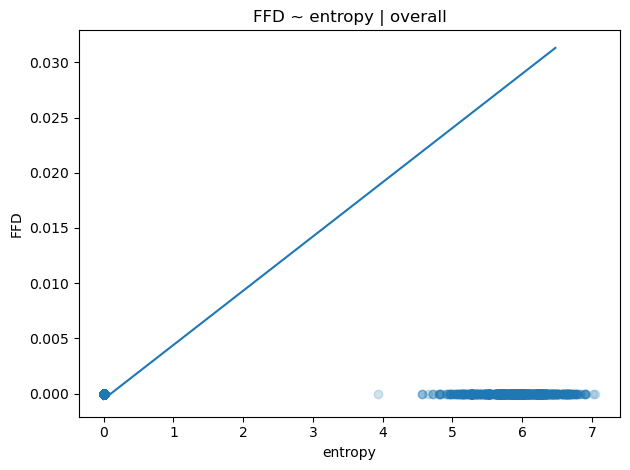

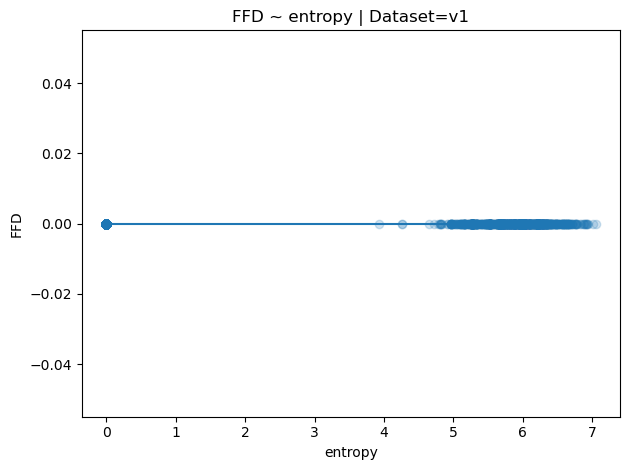

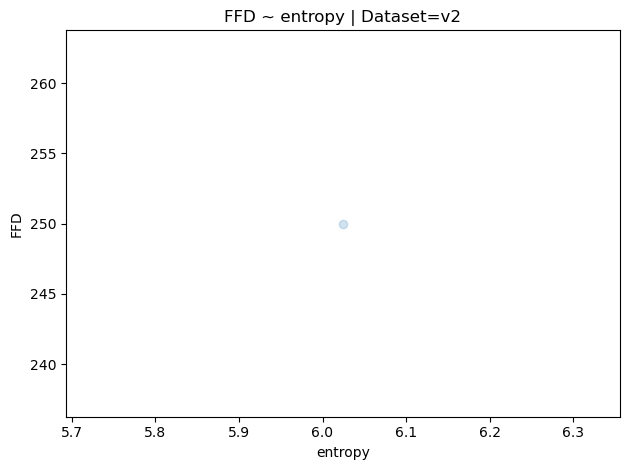

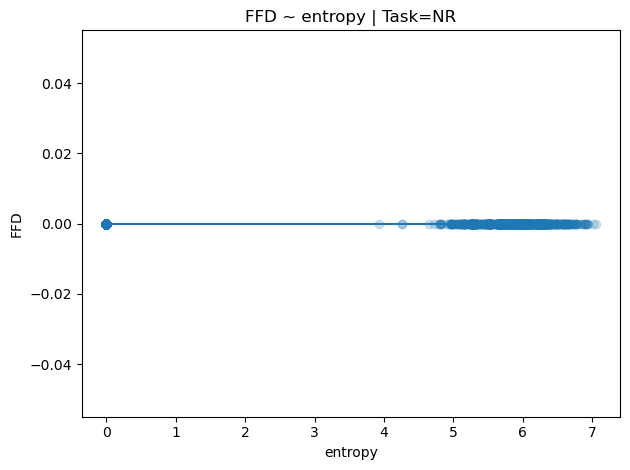

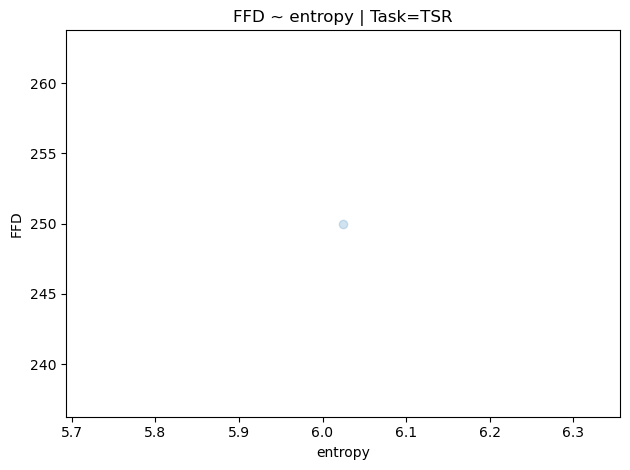

In [12]:
def partial_plot(dfin, response='FFD', xvar='entropy', controls=None, fixed_cats=None, n_points=100, savepath=None):
    controls = controls or []; fixed_cats = fixed_cats or {}
    need=[response,xvar]+controls+list(fixed_cats.keys())
    if not set(need).issubset(dfin.columns): return
    formula=response+' ~ '+xvar
    if controls: formula+=' + '+' + '.join(controls)
    for k in fixed_cats:
        if k in dfin.columns and dfin[k].dtype=='O': formula+=f' + C({k})'
    mod=smf.ols(formula, data=dfin.dropna(subset=need)).fit()
    xgrid=np.linspace(dfin[xvar].quantile(0.05), dfin[xvar].quantile(0.95), n_points)
    base={c: float(dfin[c].median()) for c in controls}; base.update(fixed_cats)
    grid=pd.DataFrame({xvar:xgrid, **base}); yhat=mod.predict(grid)
    plt.figure(); samp=dfin.dropna(subset=need).sample(min(2000,len(dfin.dropna(subset=need))), random_state=SEED)
    plt.scatter(samp[xvar], samp[response], alpha=0.2); plt.plot(xgrid, yhat)
    ttl=', '.join([f"{k}={v}" for k,v in fixed_cats.items()]) if fixed_cats else 'overall'
    plt.title(f'{response} ~ {xvar} | {ttl}'); plt.xlabel(xvar); plt.ylabel(response); plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi=150)
    plt.show()
if len(df)>0 and {'FFD','entropy'}.issubset(df.columns):
    controls=[c for c in ['length','log_freq'] if c in df.columns]
    partial_plot(df,'FFD','entropy',controls,{},savepath=Path('figures/metrics')/'F2_reading_vs_KEC.png')
    if 'Dataset' in df:
        for ds in sorted(df['Dataset'].dropna().unique()):
            dsd=df[df['Dataset']==ds]
            partial_plot(dsd,'FFD','entropy',controls,{'Dataset':ds},savepath=Path('figures/metrics')/f'F2_reading_vs_KEC_{ds}.png')
    if 'Task' in df:
        for tk in sorted(df['Task'].dropna().unique()):
            tkd=df[df['Task']==tk]
            partial_plot(tkd,'FFD','entropy',controls,{'Task':tk},savepath=Path('figures/metrics')/f'F2_reading_vs_KEC_task_{tk}.png')


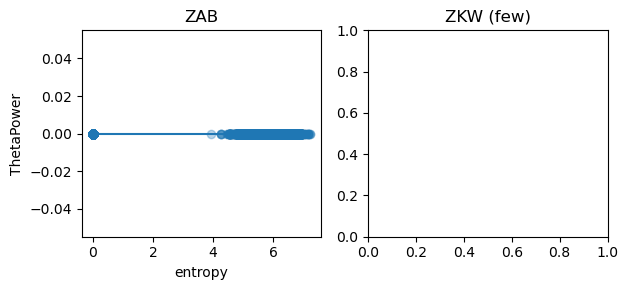

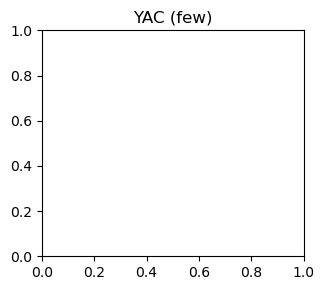

In [13]:
def per_subject_trends(dfin, eeg_col='ThetaPower', xvar='entropy', by='Dataset', saveprefix='F3_EEG_vs_KEC'):
    import math
    if not {'Subject',eeg_col,xvar}.issubset(dfin.columns): return
    groups=sorted(dfin[by].dropna().unique()) if (by and by in dfin.columns) else [None]
    for g in groups:
        dsub=dfin if g is None else dfin[dfin[by]==g]
        subs=sorted(dsub['Subject'].astype(str).unique()); nsub=len(subs)
        if nsub==0: continue
        ncols=4; nrows=int(math.ceil(nsub/ncols))
        plt.figure(figsize=(12,3*nrows))
        for i,s in enumerate(subs,1):
            ax=plt.subplot(nrows,ncols,i)
            sdf=dsub[dsub['Subject'].astype(str)==str(s)].dropna(subset=[eeg_col,xvar])
            if len(sdf)<5: ax.set_title(f'{s} (few)'); continue
            ax.scatter(sdf[xvar], sdf[eeg_col], alpha=0.3)
            try:
                m=smf.ols(f"{eeg_col} ~ {xvar}", data=sdf).fit(); xs=np.linspace(sdf[xvar].min(), sdf[xvar].max(), 50)
                ys=m.params['Intercept'] + m.params[xvar]*xs; ax.plot(xs, ys)
            except Exception: pass
            ax.set_title(str(s)); ax.set_xlabel(xvar); ax.set_ylabel(eeg_col)
        plt.tight_layout(); tag=f'_{by}_{g}' if g is not None else ''
        out=Path('figures/metrics')/f'{saveprefix}{tag}.png'; plt.savefig(out, dpi=150)
        plt.show()
if len(df)>0 and 'entropy' in df.columns and any(c in df.columns for c in ['ThetaPower','AlphaPower']):
    eegc='ThetaPower' if 'ThetaPower' in df.columns else 'AlphaPower'
    per_subject_trends(df, eeg_col=eegc, xvar='entropy', by='Dataset', saveprefix='F3_EEG_vs_KEC')


In [14]:
from statsmodels.regression.mixed_linear_model import MixedLM
def fit_mixedlm_ffd(dfin):
    req={'FFD','entropy','length','log_freq','Subject','SentenceID'}
    if not req.issubset(dfin.columns): return None
    use=['FFD','entropy','length','log_freq','Subject','SentenceID']
    if 'Task' in dfin.columns: use.append('Task')
    if 'Dataset' in dfin.columns: use.append('Dataset')
    mdf=dfin[use].dropna().copy()
    # dummies
    import pandas as pd
    for cat in ['Task','Dataset']:
        if cat in mdf.columns:
            dummies=pd.get_dummies(mdf[cat], prefix=cat, drop_first=True)
            mdf=pd.concat([mdf.drop(columns=[cat]), dummies], axis=1)
    exog_cols=[c for c in mdf.columns if c not in ['FFD','Subject','SentenceID']]
    exog=sm.add_constant(mdf[exog_cols]); endog=mdf['FFD']
    vc={'Sentence': '0 + C(SentenceID)'}
    try:
        model=MixedLM(endog, exog, groups=mdf['Subject'], vc_formula=vc)
        res=model.fit(reml=True, method='lbfgs')
        (PROC_DIR/'mixedlm_ffd_summary.txt').write_text(str(res.summary()))
        print('Saved MixedLM summary')
        return res
    except Exception as e:
        warnings.warn(f'MixedLM failed: {e}'); return None
# Uncomment to run: _=fit_mixedlm_ffd(df)


In [15]:
from joblib import Parallel, delayed

def _boot_fit_once(groups, dfin, formula, rng):
    """Fit one bootstrap sample by resampling groups with replacement and fitting OLS."""
    samp_groups = rng.choice(groups, size=len(groups), replace=True)
    samp_df = pd.concat([dfin[dfin['Subject'] == g] for g in samp_groups], ignore_index=True)
    try:
        m = smf.ols(formula, data=samp_df).fit()
        return m.params
    except Exception:
        return None


def bootstrap_coefs_parallel(dfin, formula, group_col='Subject', B=1000, n_jobs=-1, seed=42):
    """Parallel bootstrap of OLS coefficients by resampling group_col.

    Parameters:
        dfin: DataFrame containing data
        formula: Patsy formula for OLS
        group_col: Column to bootstrap at the group level (e.g., 'Subject')
        B: Number of bootstrap iterations
        n_jobs: Parallel workers (-1 uses all cores)
        seed: RNG seed
    Returns:
        DataFrame of bootstrap coefficient draws (rows=draws, cols=terms)
    """
    rng = np.random.default_rng(seed)
    groups = dfin[group_col].dropna().unique()
    seeds = rng.integers(0, 2**32 - 1, size=B, endpoint=True)

    res = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(_boot_fit_once)(groups, dfin, formula, np.random.default_rng(int(s)))
        for s in seeds
    )
    return pd.DataFrame([r for r in res if r is not None])

# Example usage:
# if len(df) > 0 and {'FFD','entropy','length','log_freq','Subject'}.issubset(df.columns):
#     boot = bootstrap_coefs_parallel(
#         df[['FFD','entropy','length','log_freq','Subject']].dropna(),
#         'FFD ~ entropy + length + log_freq',
#         B=1000, n_jobs=-1
#     )
#     boot.to_csv(Path('data/processed')/'boot_ols_ffd_entropy.csv', index=False)
#     print('Saved bootstrap')

In [16]:
%pip install joblib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [17]:
from datetime import datetime, timezone
import json
from pathlib import Path

# Build QA with dynamic timestamp and safe guards
now = datetime.now(timezone.utc).isoformat().replace("+00:00", "Z")
rows = int(len(df)) if 'df' in locals() and isinstance(df, pd.DataFrame) else 0
cols = list(df.columns) if 'df' in locals() and isinstance(df, pd.DataFrame) else []

qa = {
    'timestamp_utc': now,
    'merged_rows': rows,
    'et_cols': [c for c in ('FFD','GD','log_TRT','log_GPT') if c in cols],
    'kec_cols': [c for c in ('entropy','curvature','coherence') if c in cols],
    'cat_covs': [c for c in ('Dataset','Task') if c in cols],
    'reading_coeffs_csv': str(PROC_DIR/'models_reading_coeffs.csv') if 'PROC_DIR' in locals() and (PROC_DIR/'models_reading_coeffs.csv').exists() else None,
    'reading_coeffs_fdr_csv': str(PROC_DIR/'models_reading_coeffs_fdr.csv') if 'PROC_DIR' in locals() and (PROC_DIR/'models_reading_coeffs_fdr.csv').exists() else None,
    'mixedlm_summary': str(PROC_DIR/'mixedlm_ffd_summary.txt') if 'PROC_DIR' in locals() and (PROC_DIR/'mixedlm_ffd_summary.txt').exists() else None,
    'fig_f2': [str(p) for p in Path('figures/metrics').glob('F2_reading_vs_KEC*.png')],
    'fig_f3': [str(p) for p in Path('figures/metrics').glob('F3_EEG_vs_KEC*.png')],
}

# Ensure reports directory and write QA
Path('reports').mkdir(parents=True, exist_ok=True)
(Path('reports')/'qa_kec_models.json').write_text(json.dumps(qa, indent=2))
print('Saved QA', qa['timestamp_utc'])

Saved QA 2025-09-02T09:34:28.693569Z
